# Imports

In [ ]:
import optuna

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

from src.preprocessing import preprocess_data
from src.utils.compute_metrics import compute_and_store_metrics
from src.utils.confusion_matrix import plot_confusion_matrix
from src.utils.load_data import load_data
from src.utils.save_model import save_model
from src.utils.cumulative_probability import plot_cumulative_probability
from src.utils.plot_roc import plot_roc_curve

ModuleNotFoundError: No module named 'src.utils.cumulative_probabilities'

# Load Data

In [2]:
X, y = preprocess_data(load_data())

# Model

In [3]:
## Train Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [4]:
# Train a standard decision tree to create the partitions
tree_partition = DecisionTreeClassifier(max_leaf_nodes=8, random_state=42, class_weight="balanced")
tree_partition.fit(X_train, y_train)

# Get the leaf id for each training sample
leaf_ids = tree_partition.apply(X_train)
unique_leaves = np.unique(leaf_ids)

# Train a penalized logistic regression model for each leaf
leaf_models = {}
for leaf in unique_leaves:
    # Get data for the current leaf
    X_train_leaf = X_train[leaf_ids == leaf]
    y_train_leaf = y_train[leaf_ids == leaf]

    # Create and train a L2 penalized model
    leaf_model = LogisticRegression(
        penalty="l2", C=0.1, solver="liblinear"
    )
    leaf_model.fit(X_train_leaf, y_train_leaf)
    leaf_models[leaf] = leaf_model


print(f"Trained {len(leaf_models)} logistic regression models, one for each leaf.")

Trained 8 logistic regression models, one for each leaf.


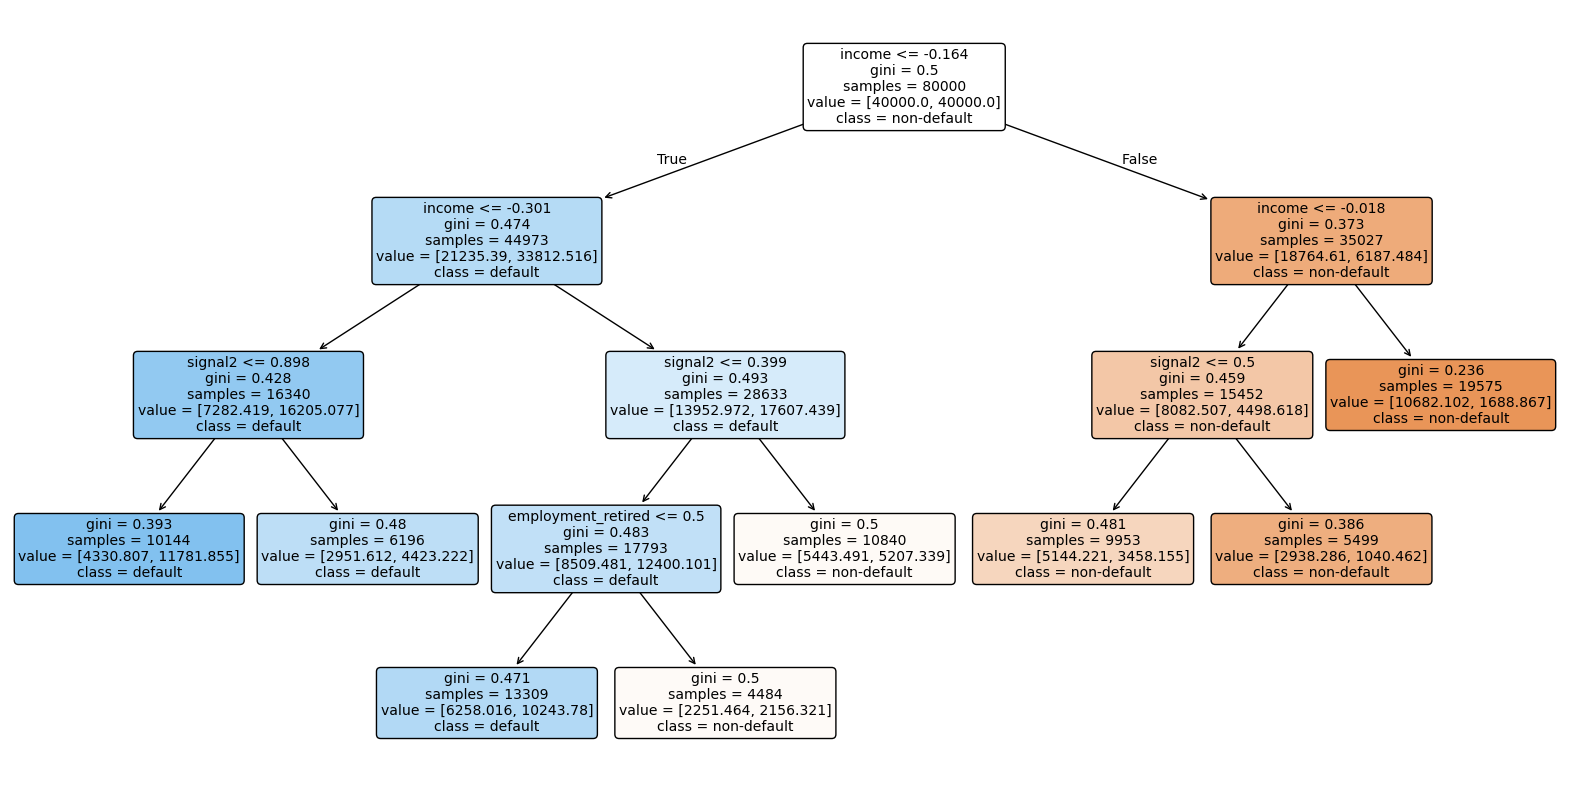

In [5]:
# Create and display the plot
plt.figure(figsize=(20, 10))
plot_tree(
    tree_partition,
    feature_names=X_train.columns,
    class_names=["non-default", "default"],
    filled=True,
    rounded=True,
)
plt.show()

In [6]:
def predict(X_new):
    # Find which leaf each new sample falls into
    new_leaf_ids = tree_partition.apply(X_new)

    # Use the corresponding leaf model to predict
    predictions = np.zeros(len(X_new))
    for leaf, model in leaf_models.items():
        indices = np.where(new_leaf_ids == leaf)[0]
        if len(indices) > 0:
            predictions[indices] = model.predict_proba(X_new.iloc[indices])[:, 1]

    return predictions

In [7]:
y_pred_proba = predict(X_test)

In [24]:
threshold = 0.15
y_pred = (y_pred_proba >= threshold).astype(int)

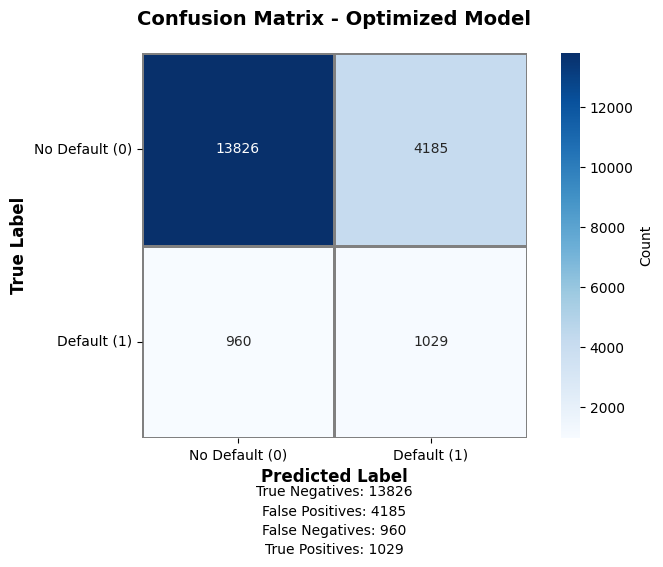


Model Metrics:
Accuracy:  0.7428 (74.28%)
Precision: 0.1974 (19.74%)
Recall:    0.5173 (51.73%)
F1-Score:  0.2857 (28.57%)


In [25]:
plot_confusion_matrix(y_test, y_pred, cmap="Blues")

In [19]:
auc_score = roc_auc_score(y_test, y_pred_proba)

print(f"The AUC score is: {auc_score:.4f}")

The AUC score is: 0.7211


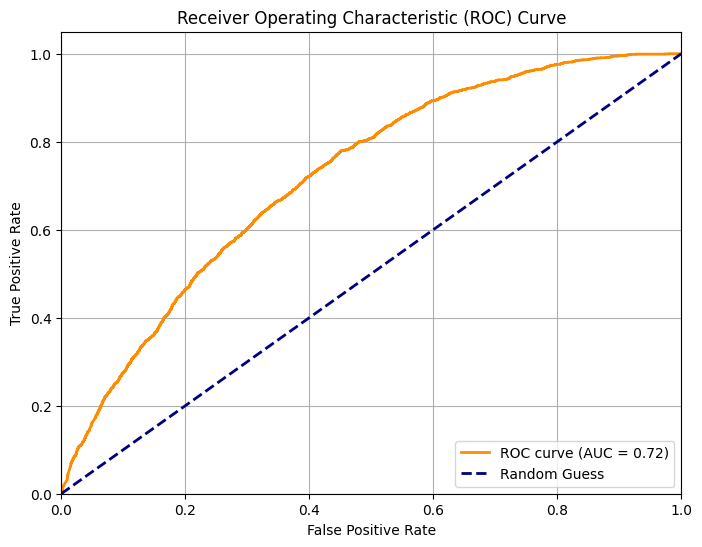

In [21]:
# Call the function with your data
plot_roc_curve(y_test, y_pred_proba)

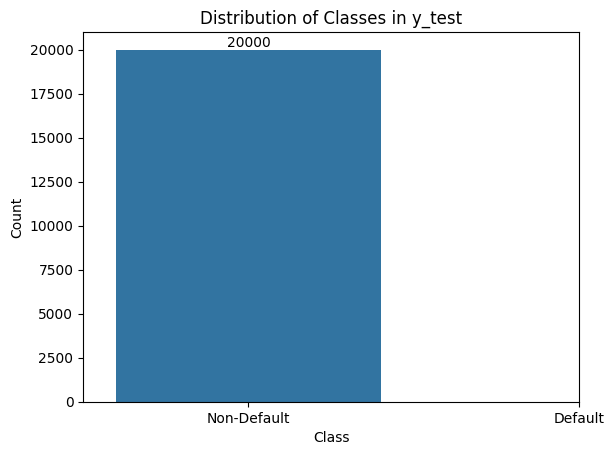

In [16]:
# Assign the plot to an 'ax' variable to access its properties
ax = sns.countplot(x=y_pred)

# Use the bar_label method to add labels
# ax.containers[0] gets the group of bars from the plot
ax.bar_label(ax.containers[0])

ax.set_title("Distribution of Classes in y_test")
ax.set_xlabel("Class")
ax.set_ylabel("Count")
ax.set_xticks([0, 1], ["Non-Default", "Default"])
plt.show()

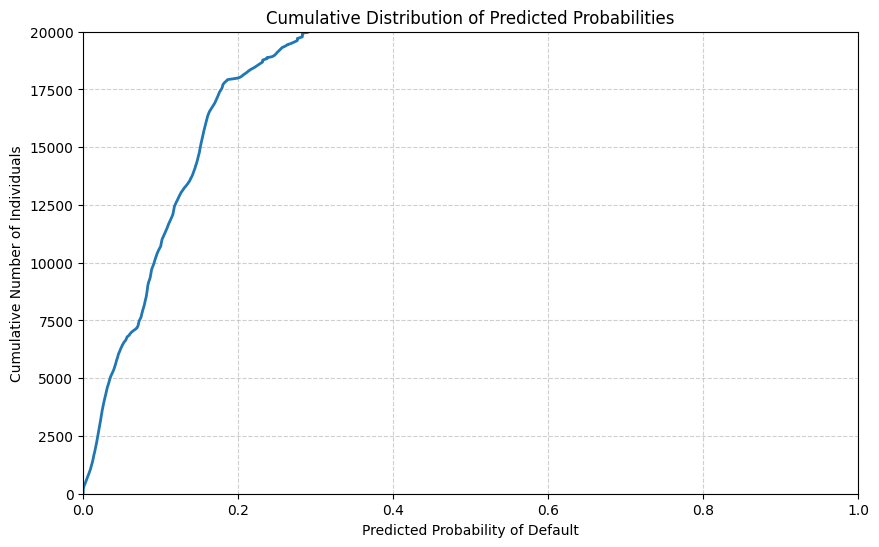

In [15]:
plot_cumulative_probability(y_pred_proba)

## Hyperparameter fine-tuning (Optuna)

In [ ]:
def objective(trial):
    # Suggest hyperparameters
    n_estimators = ...
    max_depth = ...
    min_samples_split = ...

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred_proba = model.predict_proba(X_test)[
        :, 1
    ]  # Probability estimates for the positive class (default)
    y_pred = (y_pred_proba >= threshold).astype(int)

    # Calculate F1-score (or any other metric you prefer)
    from sklearn.metrics import f1_score

    score = f1_score(y_test, y_pred)

    return score


# Create and run the study
study = optuna.create_study(direction="maximize")  # Maximize F1-score
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("\n" + "=" * 60)
print("BEST HYPERPARAMETERS")
print("=" * 60)
print(f"Best F1-Score: {study.best_value:.4f}")
print(f"\nBest Parameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

In [ ]:
# Train the final model with best parameters
best_params = study.best_params

model = ...(
    ...  # Use best_params to set hyperparameters
)
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= best_params["threshold"]).astype(int)

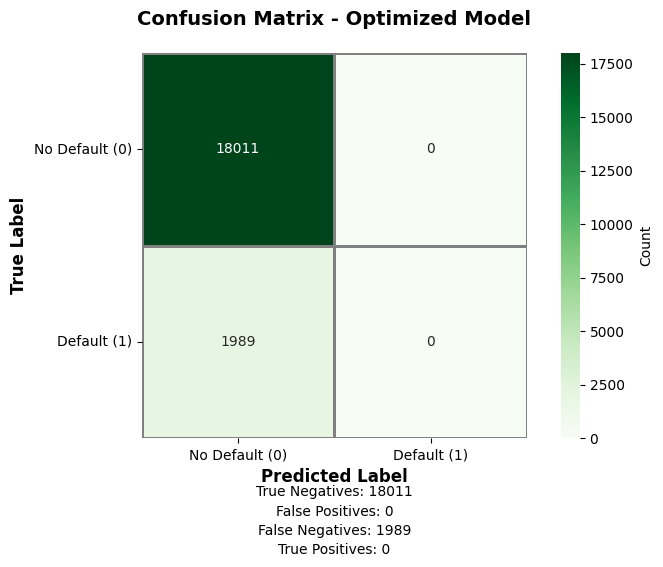


Model Metrics:
Accuracy:  0.9005 (90.05%)
Precision: 0.0000 (0.00%)
Recall:    0.0000 (0.00%)
F1-Score:  0.0000 (0.00%)


In [29]:
plot_confusion_matrix(y_test, y_pred, cmap="Greens")

In [28]:
compute_and_store_metrics(y_test, y_pred, model_name="Model_Name")

In [ ]:
# Final training on the entire dataset
model = ...
model.fit(X, y)
save_model(model, model_name="Model_Name")